# Create a solenoid fieldmap from on-axis data

In [1]:
%load_ext autoreload    
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
from numpy import sin, cos, pi, arange
import os

# Original data

In [4]:
# Here is some on-axis data
BDAT = 'templates/solenoid/newSOL.dat'

Text(0.5, 1.0, '100 points')

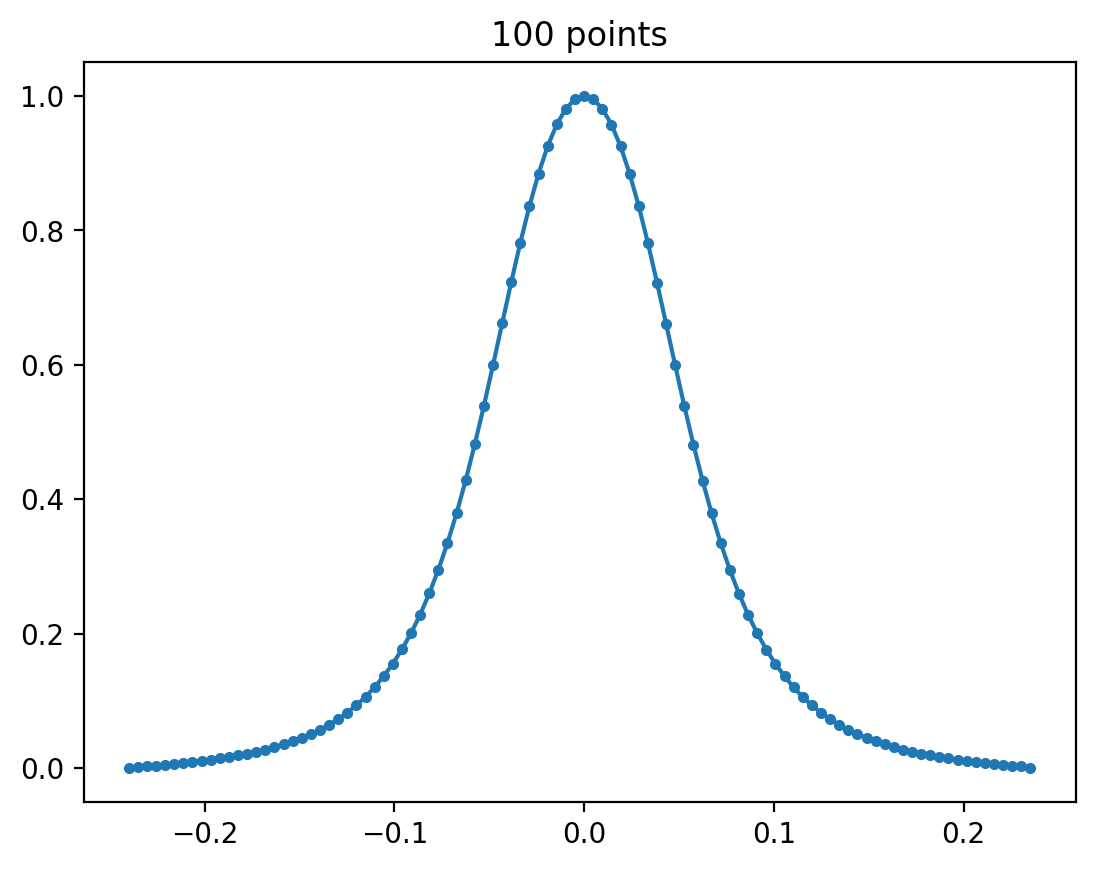

In [5]:
DAT = np.loadtxt(BDAT).T
Z, BZ = DAT[0], DAT[1]/DAT[1].max()

# Test odd number of points
Z  = Z[:-1]
BZ = BZ[:-1]

SKIP = 100 # Thin out data for visualization

Z = Z[::SKIP]
BZ = BZ[::SKIP]

# Get spacing
DZ = np.diff(Z)
assert np.allclose(DZ, DZ[0])
DZ = DZ[0]
L = Z.ptp()


#BZ *= sin(100*Z)

# Test for odd number of points

BZ[-1] = BZ[0] # assert periodicity

plt.plot(Z, BZ, marker='.')
plt.title(f'{len(Z)} points')

# RFcoef Fortran program

In [6]:
from pmd_beamphysics.interfaces.impact import create_fourier_coefficients


N_COEF = 30

fcoefs1 = create_fourier_coefficients(Z, BZ, n= N_COEF)

In [7]:
from impact.fieldmaps import run_RFcoef


res = run_RFcoef(Z, BZ, n_coef=N_COEF, exe="$HOME/Code/GitHub/IMPACT-T/utilities/RFcoeflcls")

rfdatax = res['rfdatax'] 
rfdatax2 = res['rfdatax2']
rfdataout = res['rfdata.out']
rfdatax, len(rfdatax2)

 How many Fourier coeficients you want?
 zdata1:  -0.23999999999999999       0.23524752475200000     
 The RF data number is:          100  0.47524752475199999       -2.3762376239999938E-003   4.8004800480000000E-003
 input # of data points:
 input shift length:


(array([ 5.42705923e-01,  4.07198343e-01,  1.27961010e-02,  2.02813299e-01,
         1.27611784e-02,  8.62184081e-02,  8.14816617e-03,  2.85467763e-02,
         3.60880031e-03,  7.45965340e-03,  1.17835464e-03, -5.70108776e-04,
        -1.04973269e-04, -1.48618844e-03, -3.36632027e-04, -1.62102601e-03,
        -4.11120606e-04, -6.58183360e-04, -1.96978748e-04, -4.86182447e-04,
        -1.51533090e-04,  9.23799976e-06, -3.81259184e-06, -8.87381419e-05,
        -2.72904675e-05,  1.17575737e-04,  4.23007555e-05, -4.19844419e-05,
        -1.04293570e-05,  8.46257704e-05,  3.30236446e-05, -4.99456219e-05,
        -1.65556946e-05,  5.56770970e-05,  2.12098445e-05, -4.95775231e-05,
        -1.88814993e-05,  4.41203349e-05,  1.65127549e-05, -4.29583455e-05,
        -1.68087956e-05,  3.84925501e-05,  1.44814969e-05, -3.69103101e-05,
        -1.41297937e-05,  3.53042838e-05,  1.36552899e-05, -3.18028636e-05,
        -1.12370030e-05,  3.22623776e-05,  1.24401138e-05, -2.89946504e-05,
        -9.7

# Reconstruction


The coefficients in these files are defined so that a field $E$ can be reconstructed at position $z$ as 

$ E(z) = A_0 + \sum_{n=1}^{N} A_n \cos\left(2\pi n \frac{z}{L} \right) + B_n \sin\left(2\pi n \frac{z}{L} \right)$

where $z~\epsilon~[-L/2, L/2]$

This function will handle this efficiently.

In [8]:
from pmd_beamphysics.interfaces.impact import fourier_field_reconsruction

Text(0, 0.5, 'reconstruction error')

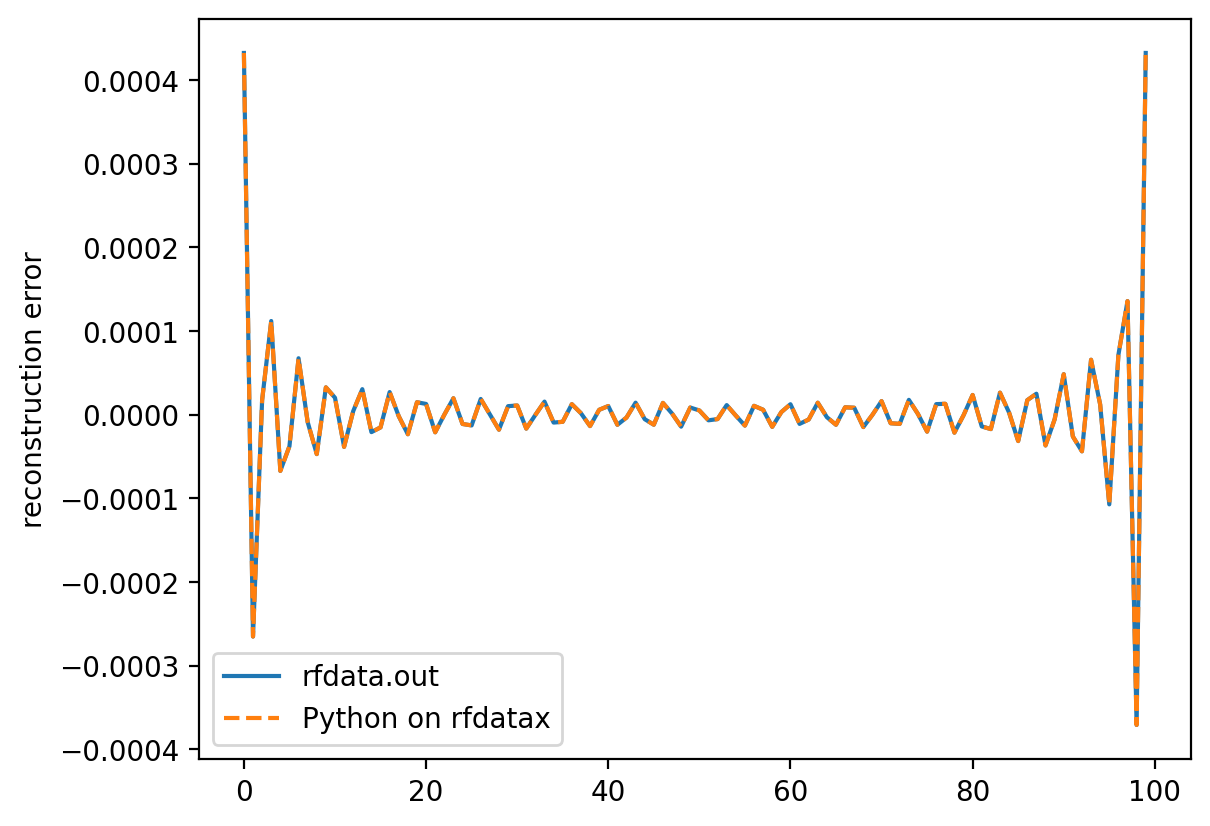

In [9]:
@np.vectorize
def f0(z):
    return fourier_field_reconsruction(z, rfdatax, z0=Z.min(), zlen=L)
    
rBZ0 = f0(Z)
errx = rfdataout[:,1] - BZ
err0 = (rBZ0 - BZ)
    
fig, ax = plt.subplots()    
#ax.plot(rBZ0, label='reconstructed')
ax.plot(errx, label='rfdata.out')
ax.plot(err0, '--', label='Python on rfdatax')
ax.legend()
ax.set_ylabel('reconstruction error')

# Create coefficients via FFT

In [10]:
from pmd_beamphysics.interfaces.impact import create_fourier_coefficients_via_fft

Text(0, 0.5, 'reconstruction error')

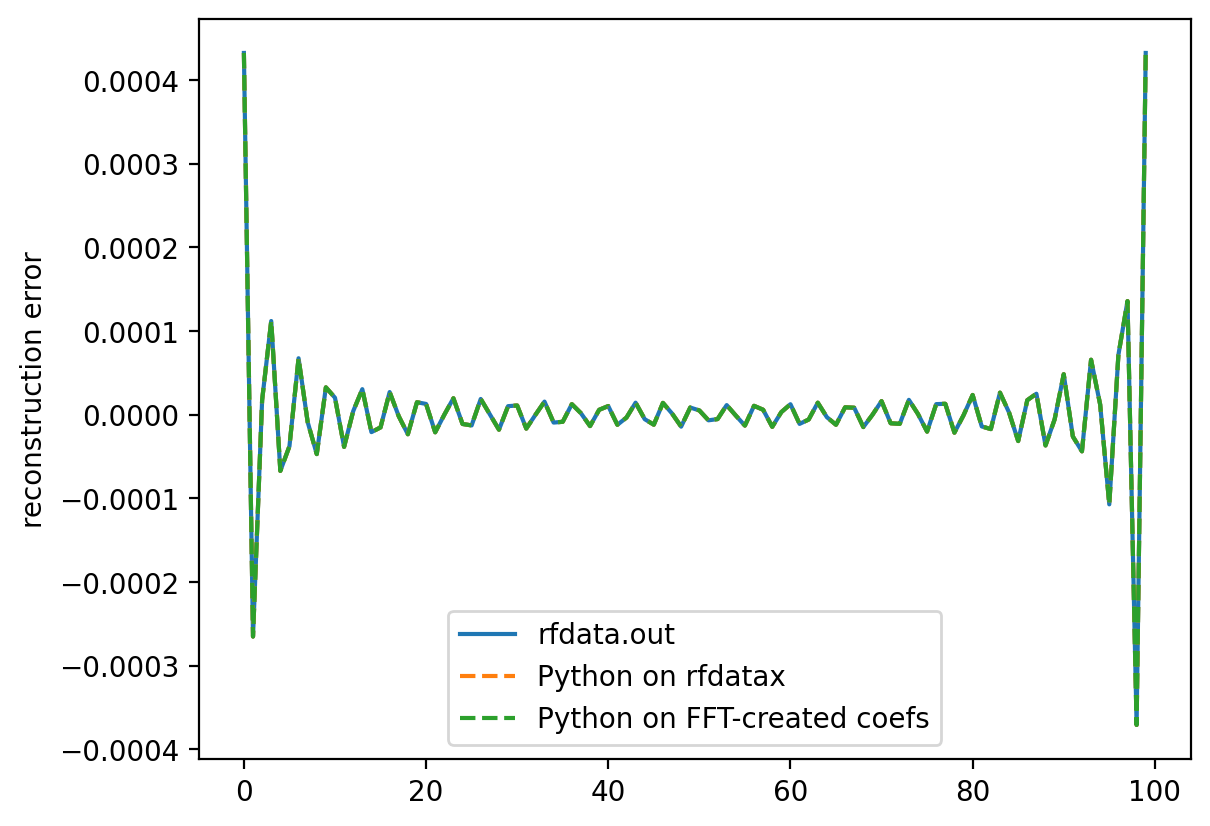

In [11]:
fcoefs1 = create_fourier_coefficients_via_fft(BZ, n_coef=N_COEF)

@np.vectorize
def f1(z):
    return fourier_field_reconsruction(z, fcoefs1, z0=Z.min(), zlen=L)

rBZ1 = f1(Z)
err1 = rBZ1 - BZ

plt.plot(errx, label='rfdata.out')
plt.plot(err0, '--', label='Python on rfdatax')
plt.plot(err1, '--', label='Python on FFT-created coefs')
plt.legend()
plt.ylabel('reconstruction error')

In [12]:
from impact import fieldmaps
?fieldmaps.create_fourier_coefficients

Signature: fieldmaps.create_fourier_coefficients(zdata, edata, n=None)
Docstring:
Literal transcription of Ji's routine RFcoeflcls.f90

https://github.com/impact-lbl/IMPACT-T/blob/master/utilities/RFcoeflcls.f90

Fixes bug with scaling the field by the max or min seen.

Vectorized two loops

Parameters
----------
zdata: ndarray
    z-coordinates

edata: ndarray
    field-coordinates

n: int
    Number of Fourier coefficient to compute.
    None => n = len(edata) //2 + 1
    Default: None

Returns
-------    
rfdata: ndarray of float
    Impact-T style Fourier coefficients
File:      ~/Code/GitHub/openPMD-beamphysics/pmd_beamphysics/interfaces/impact.py
Type:      function


# Create LUME-Impact style fieldmap

In [13]:
# Get basic placement
zmin, zmax = Z.min(), Z.max()
Ltot = zmax - zmin
zmin, zmax, Ltot

(-0.24, 0.235247524752, 0.475247524752)

In [14]:
# Create a lume-impact style fieldmap and process into flat 1D rfdata
fmap =  {'info': {'format': 'solrf'},
    'field': {'Ez': {'z0': 0.0, 'z1': 0.0, 'L': 0.0, 'fourier_coefficients': np.array([0.])},
               'Bz': {'z0': 0, 'z1': Ltot, 'L': Ltot, 'fourier_coefficients': fcoefs1 }
             } }
    

rfdata = fieldmaps.data_from_solrf_fieldmap(fmap)    
rfdata

array([ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.90000000e+01,  0.00000000e+00,  4.75247525e-01,
        4.75247525e-01,  5.42705923e-01,  4.07198349e-01,  1.27961009e-02,
        2.02813308e-01,  1.27611786e-02,  8.62184150e-02,  8.14816659e-03,
        2.85467802e-02,  3.60880070e-03,  7.45965519e-03,  1.17835488e-03,
       -5.70108243e-04, -1.04973154e-04, -1.48618837e-03, -3.36632014e-04,
       -1.62102617e-03, -4.11120622e-04, -6.58183475e-04, -1.96978791e-04,
       -4.86182570e-04, -1.51533108e-04,  9.23797196e-06, -3.81262064e-06,
       -8.87381842e-05, -2.72904628e-05,  1.17575756e-04,  4.23007403e-05,
       -4.19844594e-05, -1.04293408e-05,  8.46257962e-05,  3.30236309e-05,
       -4.99456384e-05, -1.65556756e-05,  5.56771191e-05,  2.12098276e-05,
       -4.95775419e-05, -1.88814796e-05,  4.41203539e-05,  1.65127346e-05,
       -4.29583642e-05, -1.68087741e-05,  3.84925680e-05,  1.44814741e-05,
       -3.69103283e-05, -

In [15]:
# This simply writes 'data' this to a file
fieldmaps.write_fieldmap('templates/solenoid/rfdata666', fmap)

In [16]:
zcenter = 0.24653 # Intended center

ele = {'description': 'name:SOL1B',
 'L': Ltot,
 'type': 'solrf',
 'zedge': zcenter + zmin,
 'rf_field_scale': 0.0,
 'rf_frequency': 0.0,
 'theta0_deg': 0.0,
 'filename': 'rfdata666',
 'radius': 0.15,
 'x_offset': 0.0,
 'y_offset': 0.0,
 'x_rotation': 0.0,
 'y_rotation': 0.0,
 'z_rotation': 0.0,
 'solenoid_field_scale': 0.057,
 'name': 'SOL1'}
ele

{'description': 'name:SOL1B',
 'L': 0.475247524752,
 'type': 'solrf',
 'zedge': 0.006530000000000008,
 'rf_field_scale': 0.0,
 'rf_frequency': 0.0,
 'theta0_deg': 0.0,
 'filename': 'rfdata666',
 'radius': 0.15,
 'x_offset': 0.0,
 'y_offset': 0.0,
 'x_rotation': 0.0,
 'y_rotation': 0.0,
 'z_rotation': 0.0,
 'solenoid_field_scale': 0.057,
 'name': 'SOL1'}

In [17]:
import impact
# This is the line to add to ImpactT.in
impact.lattice.ele_line(ele)

'0.475247524752 0 0 105 0.006530000000000008 0.0 0.0 0.0 666 0.15 0.0 0.0 0.0 0.0 0.0 0.057 /!name:SOL1'

# New-style solRF field

 How many Fourier coeficients you want?
 zdata1:   -6.0000000000000000        6.0000000000000000     
 The RF data number is:         1000   12.000000000000000        0.0000000000000000        1.2012012012012012E-002
 input # of data points:
 input shift length:


((1000, 4), (1000, 4))

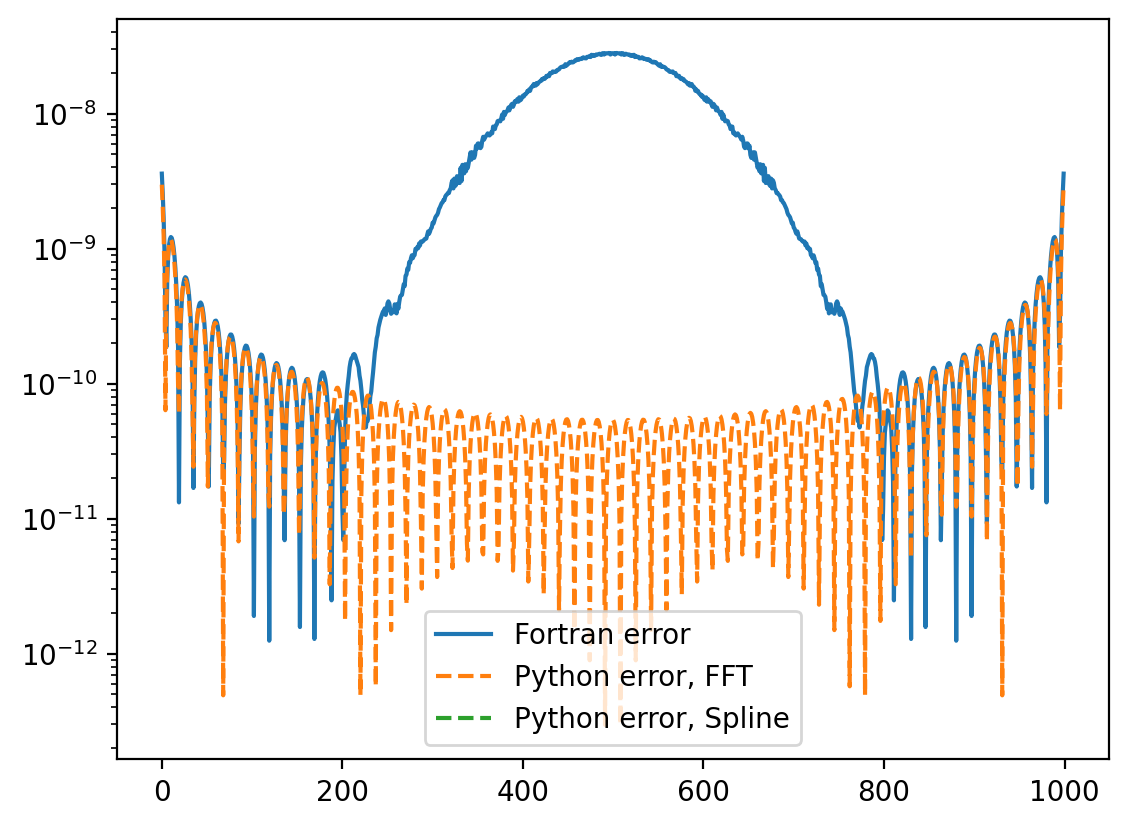

In [18]:
from pmd_beamphysics.fields.expansion import fft_derivative_array, spline_derivative_array
from impact.fieldmaps import run_RFcoef


from numpy import sqrt, pi, exp
def gaussian_derivatives(z):
    f0 =  1/sqrt(2*pi) *exp(- z**2 / 2)    
    return np.array([1* f0,
                     (-z) * f0, 
                     (-1 + z**2) * f0, 
                     (3*z - z**3)* f0]).T

ZZ = np.linspace(-6, 6, 1000)
DZ = np.diff(ZZ)[0]

AFZ = gaussian_derivatives(ZZ)
AFZ /= AFZ[:,0].max() # Normalize for comparisons

FZ = AFZ[:,0]

N_COEF = 30
rfdatax2 = run_RFcoef(ZZ, FZ, n_coef=N_COEF, exe="$HOME/Code/GitHub/IMPACT-T/utilities/RFcoeflcls")['rfdatax2'][1:]
myrfdatax2 = fft_derivative_array(FZ, ncoef = N_COEF, dz=DZ)

myrfdatax2_spline = spline_derivative_array(ZZ, FZ)


ORDER = 0
plt.plot(abs(  rfdatax2[:,ORDER] - AFZ[:, ORDER]), label='Fortran error')#
plt.plot(abs(myrfdatax2[:,ORDER] - AFZ[:, ORDER]), '--', label='Python error, FFT')#
plt.plot(abs(myrfdatax2_spline[:,ORDER] - AFZ[:, ORDER]), '--', label='Python error, Spline')#
plt.legend()
plt.yscale('log')


rfdatax2.shape, myrfdatax2.shape

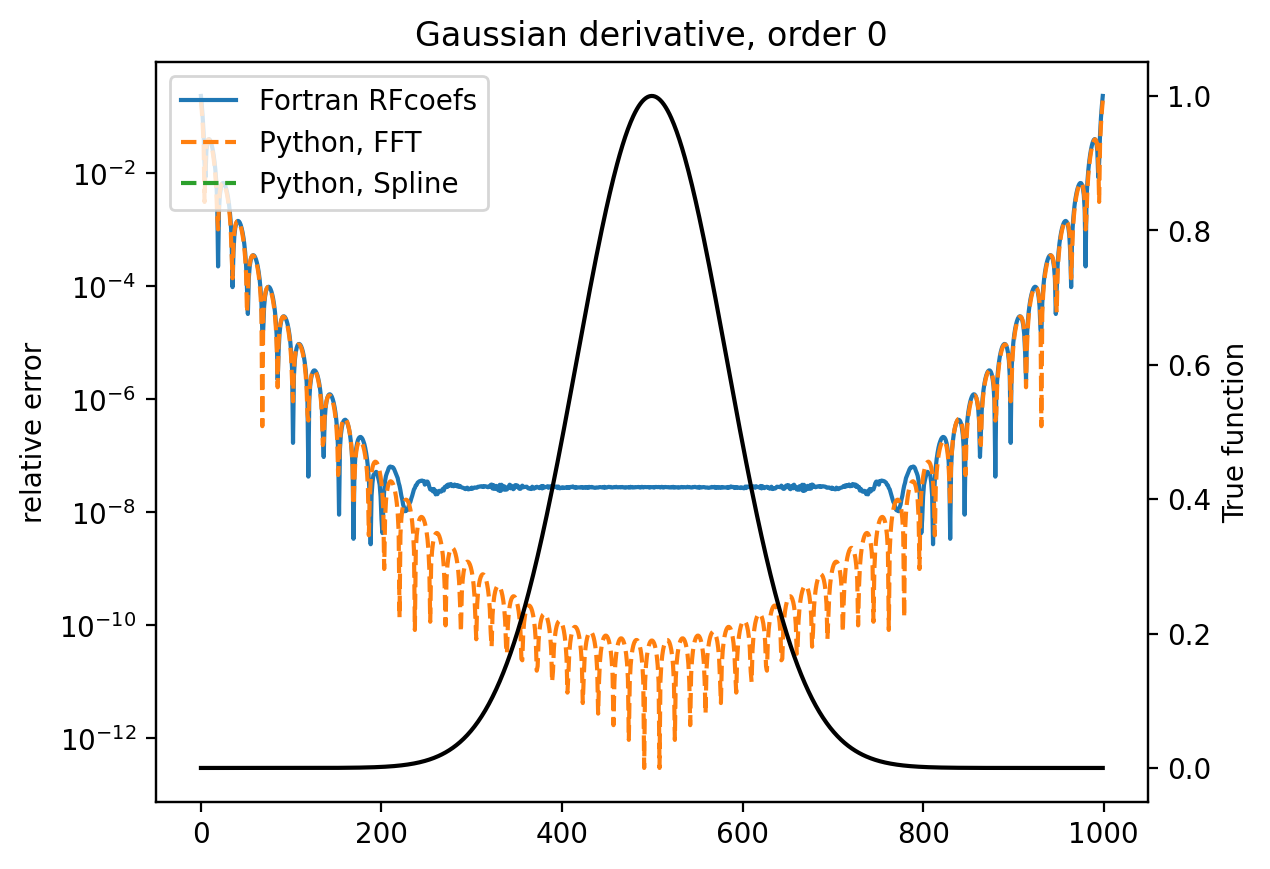

In [19]:
def compare(order):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    
    f0 = AFZ[:,order]
    f1 = rfdatax2[:,order]
    f2 = myrfdatax2[:,order]
    f3 = myrfdatax2_spline[:,order]
    
    err1 = abs((f1-f0)/f0)
    err2 = abs((f2-f0)/f0)
    err3 = abs((f3-f0)/f0)
    ax2.plot( f0   , label='Reference', color='black')#
    #ax2.plot( f1   , label='Fortran')#
    #ax2.plot( f2, '--', label='Python, FFT')#
    #ax2.plot( f3, '--', label='Python, Spline')#
    #ax2.legend(loc='upper right')
    
    ax.set_title(f'Gaussian derivative, order {order}')
    ax.set_ylabel('relative error')
    ax2.set_ylabel('True function')
    ax.plot( err1   , label='Fortran RFcoefs')#
    ax.plot( err2, '--', label='Python, FFT')#
    ax.plot( err3, '--', label='Python, Spline')#
    ax.set_yscale('log')
    ax.legend(loc='upper left')
    
compare(0)    

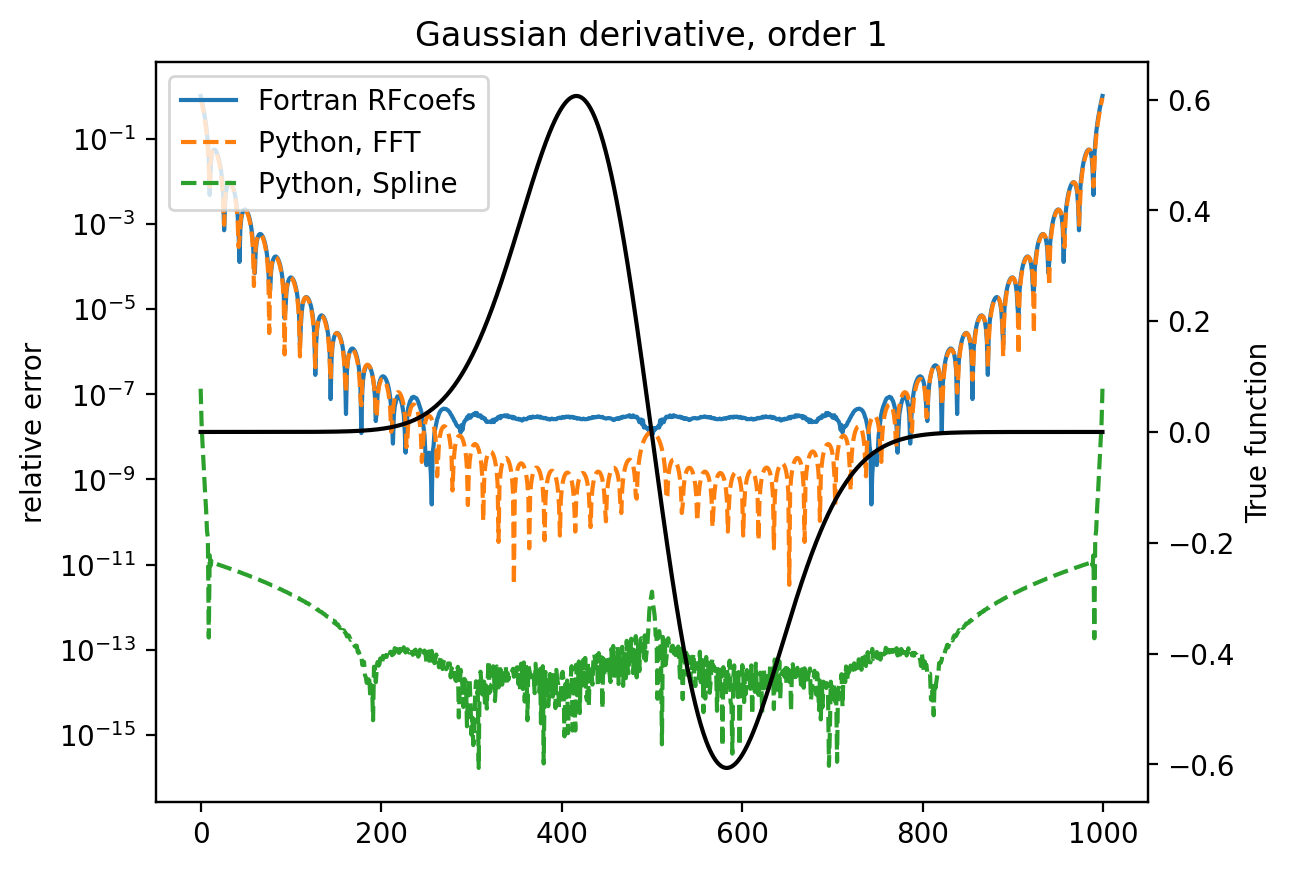

In [20]:
compare(1) 

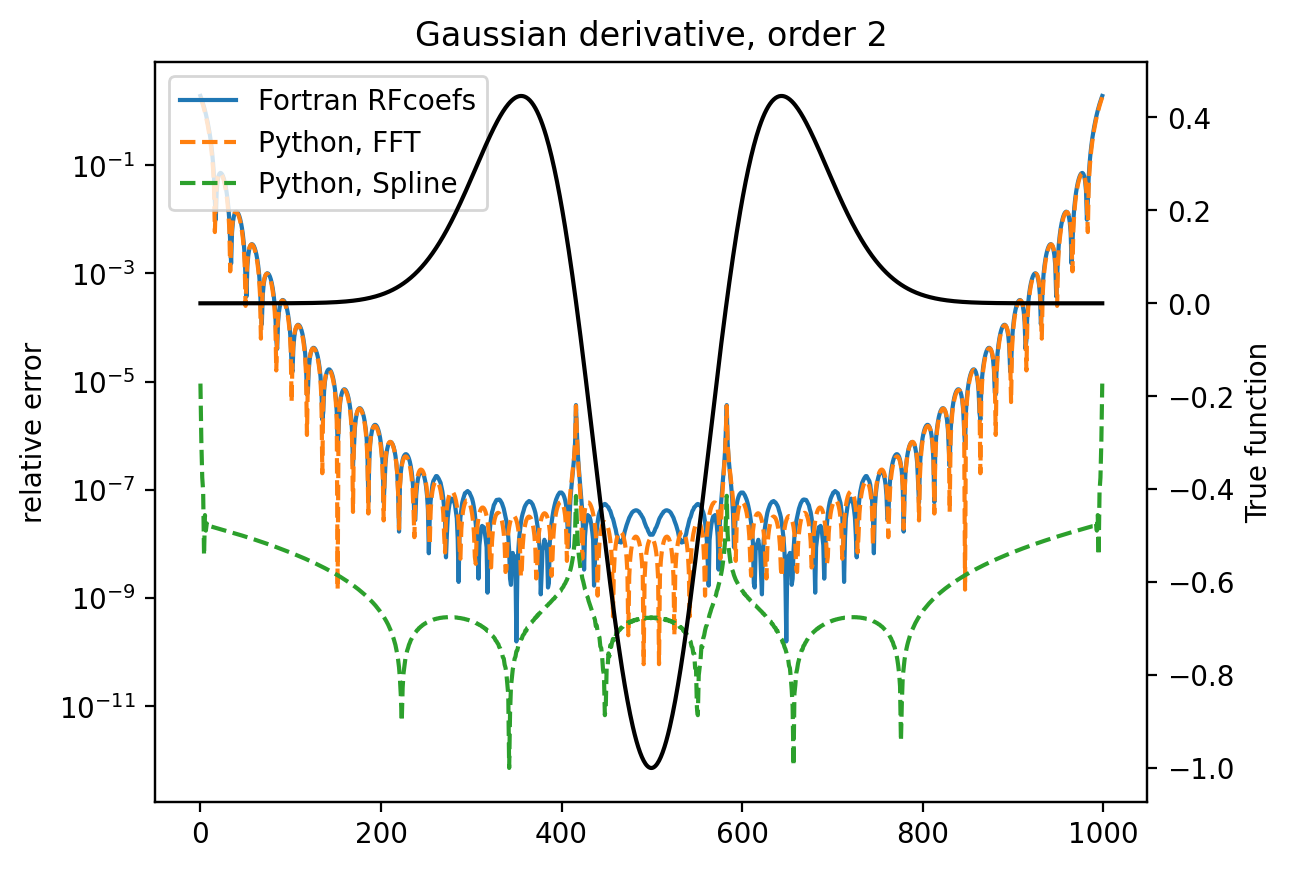

In [21]:
compare(2) 

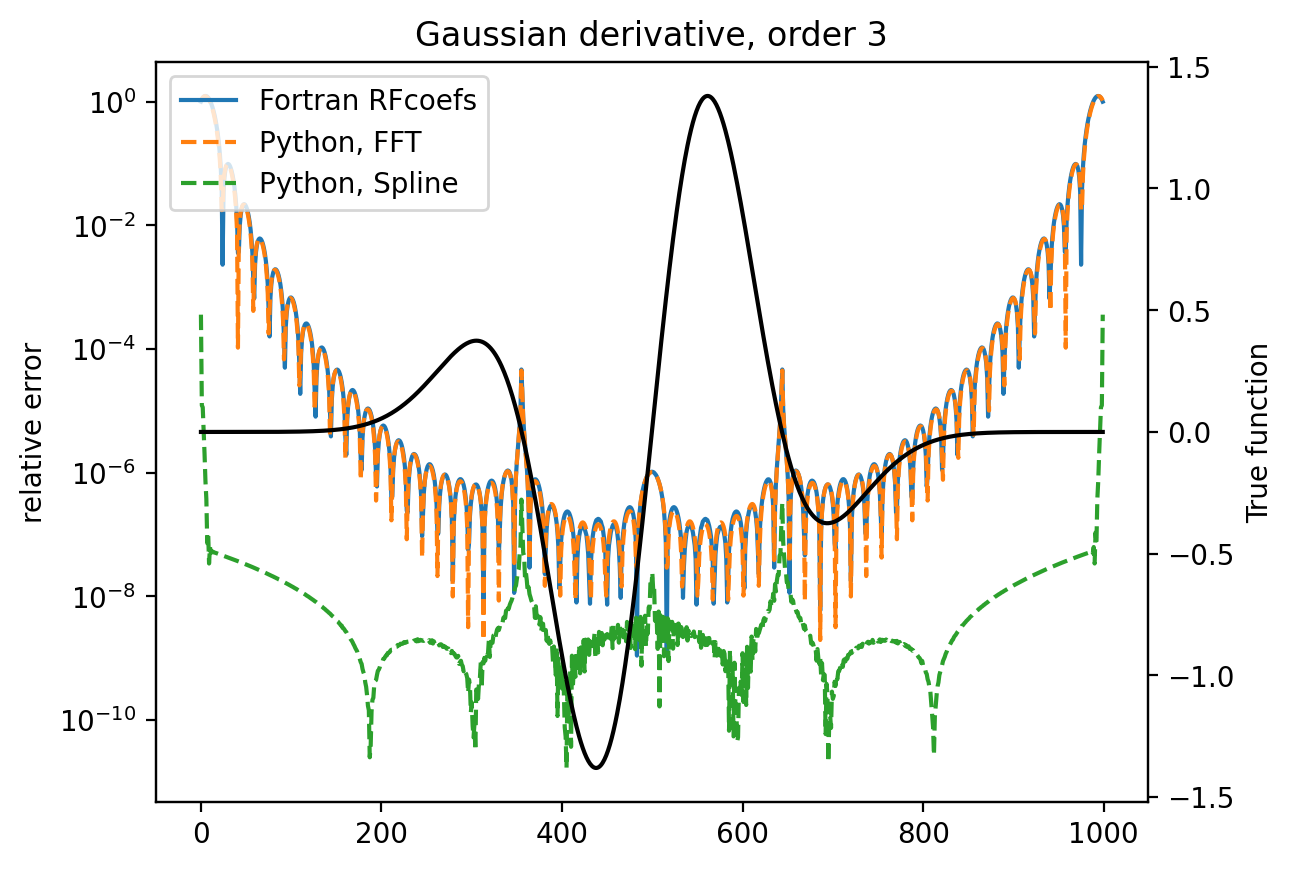

In [22]:
compare(3) 